# Data Augmentation

In [1]:
import os
import shutil
import random
from PIL import Image, ImageEnhance

SOURCE_DIR = "../data/raw_downloads" 
CLASSES_TO_PROCESS = ["7 Up", "Mountain Dew"]

TARGET_DATASET = "../data/roboflow_refrescos"

# Target Counts
TEST_COUNT = 30
VALID_COUNT = 50

In [2]:
def augment_image(img):
    """Generates 3 variations of the input image."""
    variations = []
    
    # Var 1: Original (Cleaned)
    variations.append(img)
    
    # Var 2: Rotate Left (-15 deg) - Simulates tilted bottle
    variations.append(img.rotate(15, expand=True))
    
    # Var 3: Rotate Right (+15 deg)
    variations.append(img.rotate(-15, expand=True))
    
    # Var 4: Brightness Boost (Simulates bright store lights)
    enhancer = ImageEnhance.Brightness(img)
    variations.append(enhancer.enhance(1.2))
    
    return variations

In [3]:
def process_class(class_name):
    src_path = os.path.join(SOURCE_DIR, class_name)
    if not os.path.exists(src_path):
        print(f"Source folder not found: {src_path}. Skipping.")
        return

    print(f"\nProcessing {class_name}...")
    
    # Load All Images
    all_images = []
    files = [f for f in os.listdir(src_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))]
    
    print(f"   Found {len(files)} original images.")
    
    # Augment in Memory
    augmented_pool = []
    for i, fname in enumerate(files):
        try:
            img = Image.open(os.path.join(src_path, fname)).convert('RGB')
            # Generate variations
            vars = augment_image(img)
            
            for j, var_img in enumerate(vars):
                new_name = f"{class_name}_{i}_aug{j}.jpg"
                augmented_pool.append((new_name, var_img))
        except Exception as e:
            print(f"   Error loading {fname}: {e}")

    print(f"   Generated {len(augmented_pool)} total images after augmentation.")
    
    # Shuffle & Split
    random.shuffle(augmented_pool)
    
    # Slice the list
    test_set = augmented_pool[:TEST_COUNT]
    valid_set = augmented_pool[TEST_COUNT : TEST_COUNT + VALID_COUNT]
    train_set = augmented_pool[TEST_COUNT + VALID_COUNT :]
    
    print(f"   Split stats: Train={len(train_set)}, Valid={len(valid_set)}, Test={len(test_set)}")
    
    # Save to Disk (Matching Refrescos Structure)
    # Structure: data/roboflow_refrescos/train/CLASS_NAME/img.jpg
    
    splits = {
        "train": train_set,
        "valid": valid_set,
        "test": test_set
    }
    
    for split_name, images in splits.items():
        save_dir = os.path.join(TARGET_DATASET, split_name, class_name)
        os.makedirs(save_dir, exist_ok=True)
        
        for fname, img in images:
            img.save(os.path.join(save_dir, fname))
            
    print(f"Saved to {TARGET_DATASET}")

In [4]:
if not os.path.exists(SOURCE_DIR):
    print(f"Error: Please create {SOURCE_DIR} and put '7Up' and 'Mountain Dew' folders there first.")
else:
    for cls in CLASSES_TO_PROCESS:
        process_class(cls)
    print("\nData Augmentation & Split Complete!")


Processing 7 Up...
   Found 159 original images.
   Generated 636 total images after augmentation.
   Split stats: Train=556, Valid=50, Test=30
Saved to ../data/roboflow_refrescos

Processing Mountain Dew...
   Found 135 original images.
   Generated 540 total images after augmentation.
   Split stats: Train=460, Valid=50, Test=30
Saved to ../data/roboflow_refrescos

Data Augmentation & Split Complete!


# Data Exploration post augmentation

In [6]:
import pandas as pd

# Configuration
DATASET_ROOT = "../data/roboflow_refrescos"
SPLITS = ["train", "valid", "test"]

stats = []

print(f"Dataset Statistics for: {DATASET_ROOT}\n")

if os.path.exists(DATASET_ROOT):
    # Iterate through splits
    for split in SPLITS:
        split_path = os.path.join(DATASET_ROOT, split)
        
        if os.path.exists(split_path):
            # Iterate through classes in this split
            for class_name in sorted(os.listdir(split_path)):
                class_dir = os.path.join(split_path, class_name)
                
                if os.path.isdir(class_dir):
                    # Count images
                    count = len([f for f in os.listdir(class_dir) 
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.webp'))])
                    
                    stats.append({
                        "Class": class_name,
                        "Split": split,
                        "Count": count
                    })
    
    # Create DataFrame for clean display
    if stats:
        df = pd.DataFrame(stats)
        
        # Pivot to make it a readable table (Rows=Class, Cols=Split)
        pivot_df = df.pivot(index="Class", columns="Split", values="Count").fillna(0).astype(int)
        
        # Add a Total column
        pivot_df["Total"] = pivot_df.sum(axis=1)
        
        # Reorder columns logically
        cols = ["train", "valid", "test", "Total"]
        pivot_df = pivot_df[[c for c in cols if c in pivot_df.columns]]
        
        from IPython.display import display
        display(pivot_df)
    else:
        print("No classes found. Check folder structure.")
else:
    print(f"Dataset root not found at {DATASET_ROOT}")

Dataset Statistics for: ../data/roboflow_refrescos



Split,train,valid,test,Total
Class,,,,
7 Up,556,50,30,636
Coca-cola,407,115,30,552
Fanta,417,110,30,557
Mountain Dew,460,50,30,540
Otro,444,99,0,543
Pepsi,417,114,31,562
Sprite,363,110,30,503


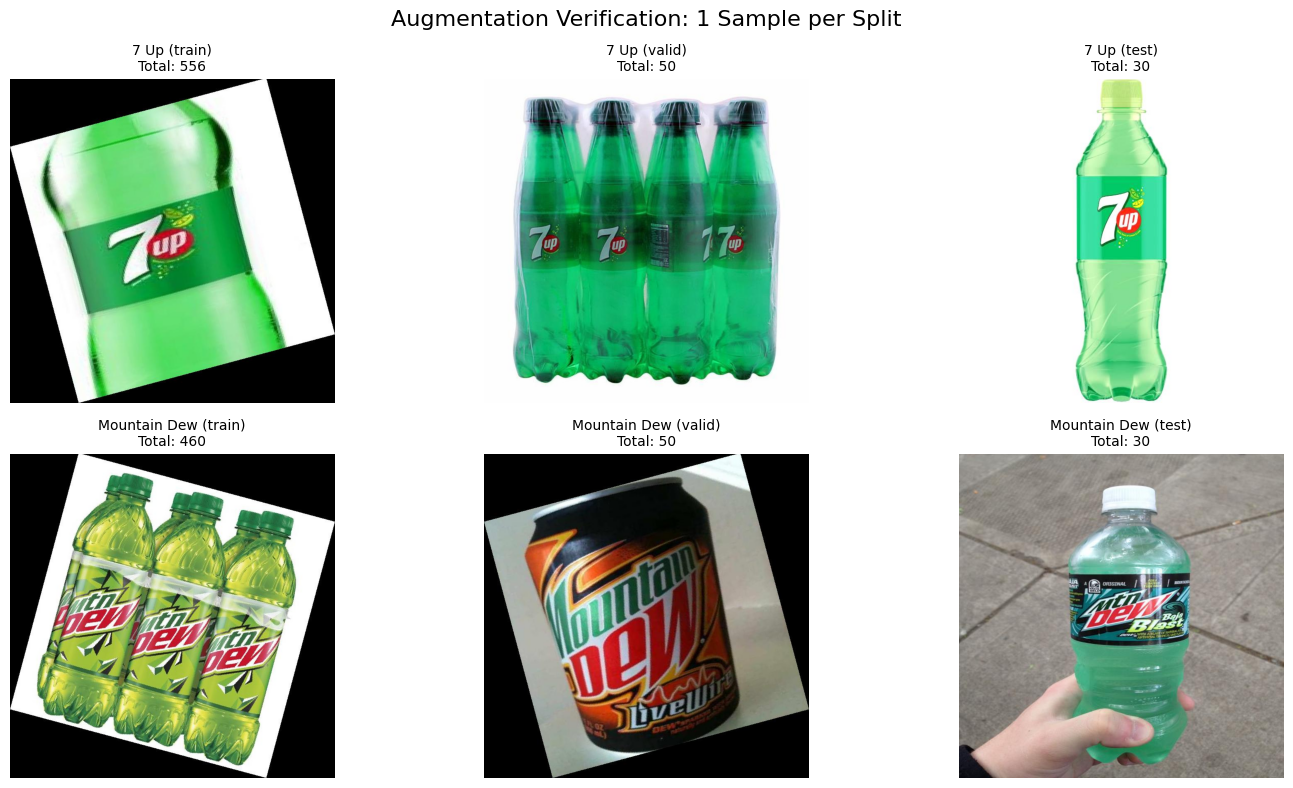

In [7]:
import matplotlib.pyplot as plt
import random

# Configuration
TARGET_DATASET = "../data/roboflow_refrescos"
CLASSES_TO_VIEW = ["7 Up", "Mountain Dew"]
SPLITS = ["train", "valid", "test"]

# Create a grid of plots (Rows = Classes, Cols = Splits)
fig, axes = plt.subplots(len(CLASSES_TO_VIEW), len(SPLITS), figsize=(15, 8))
plt.suptitle("Augmentation Verification: 1 Sample per Split", fontsize=16)

for i, class_name in enumerate(CLASSES_TO_VIEW):
    for j, split in enumerate(SPLITS):
        # Build path: ../data/roboflow_refrescos/train/7 Up
        folder_path = os.path.join(TARGET_DATASET, split, class_name)
        
        # Select axes
        ax = axes[i, j] if len(CLASSES_TO_VIEW) > 1 else axes[j]
        
        if os.path.exists(folder_path):
            files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
            
            if files:
                # Pick a random file to check variety
                img_name = random.choice(files)
                img_path = os.path.join(folder_path, img_name)
                
                # Load and Display
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(f"{class_name} ({split})\nTotal: {len(files)}", fontsize=10)
                ax.axis('off')
            else:
                ax.text(0.5, 0.5, "Empty Folder", ha='center', va='center')
        else:
            ax.text(0.5, 0.5, "Path Not Found", ha='center', va='center')
            ax.set_title(f"{class_name} ({split})")
            ax.axis('off')

plt.tight_layout()
plt.show()